In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import logging
import datetime
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# Tokenizer and stemmer initialized once
stemmer = PorterStemmer()
import concurrent.futures
from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import tensorflow as tf
import contractions, re
import string
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
from nltk.tokenize import sent_tokenize
import spacy
# Loading Spacy small model as nlp
nlp = spacy.load('en_core_web_sm')
from collections import Counter
from wordcloud import WordCloud
import math
# import warnings
# warnings.filterwarnings("ignore")


In [67]:
transcripts_data = pd.read_pickle("motley-fool-data.pkl")

In [68]:
transcripts_data.head()

,date,exchange,q,ticker,transcript
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...


## EDA

In [177]:
transcripts_data['word_count'] = transcripts_data['transcript'].apply(lambda x: len(x.split()))

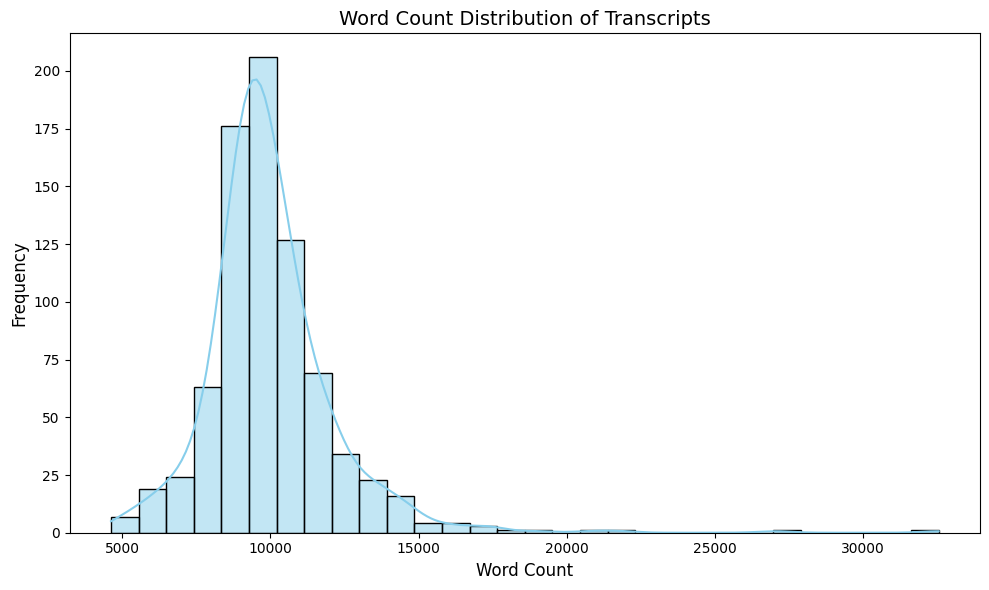

In [178]:
# Histogram of transcript lengths (word counts)
plt.figure(figsize=(10, 6))
sns.histplot(transcripts_data['word_count'], bins=30, kde=True, color='skyblue')
plt.title("Word Count Distribution of Transcripts", fontsize=14)
plt.xlabel("Word Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

### Most Frequent Words (Excluding Stop Words)

In [180]:
def get_most_frequent_words_in_batches(transcripts_data, batch_size=100, top_n=10):
    
    stop_words = set(stopwords.words('english'))
    all_words = Counter()

    # Total number of batches
    total_batches = math.ceil(len(transcripts_data) / batch_size)

    for batch_idx in range(total_batches):
        # Get a batch of transcripts
        batch = transcripts_data.iloc[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        # Process each transcript in the batch
        for transcript in batch['transcript']:
            # Tokenize and filter stop words
            tokens = word_tokenize(transcript.lower())
            filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]
            all_words.update(filtered_words)  # Update the Counter with filtered words

    # Get the top N most frequent words
    top_words = all_words.most_common(top_n)
    return top_words

/var/folders/5h/1cc6fvqn1nsf3cqhcndrlz280000gn/T/ipykernel_22211/3048358078.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words_df, x='count', y='word', palette='coolwarm')


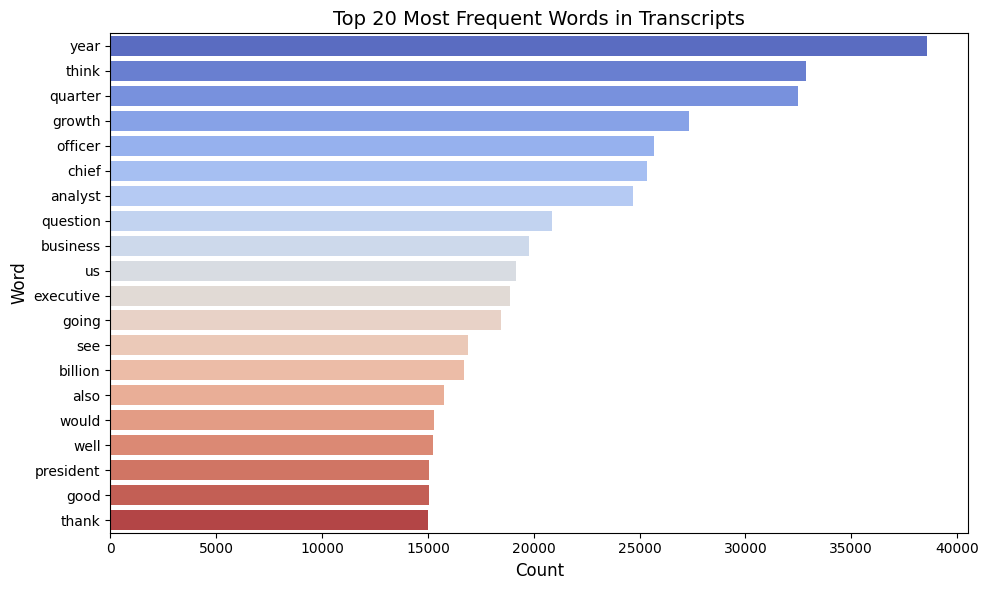

In [181]:
batch_size = 500
top_n = 20

# Get the most frequent words
top_words = get_most_frequent_words_in_batches(transcripts_data, batch_size=batch_size, top_n=top_n)

# Create a DataFrame for plotting
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=top_words_df, x='count', y='word', palette='coolwarm')
plt.title("Top 20 Most Frequent Words in Transcripts", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.tight_layout()
plt.show()

**Word Cloud of all most frequent words and most frequent custom financial vocabulary**

We need this for the relevant sentences extraction.

In [185]:
all_text = " ".join(transcripts_data['transcript'])

In [186]:
financial_terms = {"revenue", "profit", "growth", "loss", "income", "expenses", "margin", "quarter", "increased", "capital", "expect", "earnings", "market", "turn", "results"}

In [191]:
# additional custom stopwords to remove
custom_stopwords = {"quarter", "year", "think", "us", "executive", "chief", "analyst","officer","thats","thank","like","see","would","question", "and", "I", "we"}

def get_word_frequencies(text):
    """ Tokenize text into words and count frequency, excluding stopwords. """
    words = text.split()
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    words = [word for word in words if word not in stop_words]
    return Counter(words)

def process_batch(batch_data):
    """ Process a batch of transcripts and return a combined word frequency Counter. """
    all_word_frequencies = Counter()
    for transcript in batch_data:
        word_frequencies = get_word_frequencies(transcript)
        all_word_frequencies.update(word_frequencies)
    return all_word_frequencies


### WordCloud for financial terms

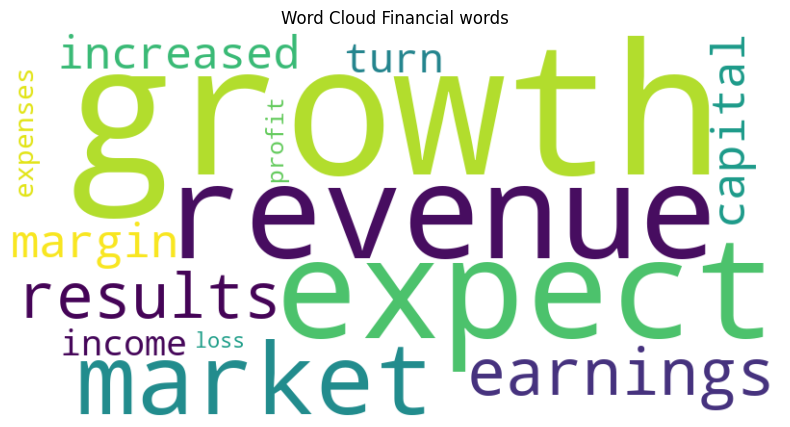

In [195]:
batch_size = 500  # Adjust this depending on available memory
batches = [transcripts_data['transcript'][i:i + batch_size] for i in range(0, len(transcripts_data), batch_size)]

final_word_frequencies = Counter()

for batch in batches:
    batch_word_frequencies = process_batch(batch)
    final_word_frequencies.update(batch_word_frequencies)



# Filter for financial terms

financial_word_frequencies = {word: count for word, count in final_word_frequencies.items() if word in financial_terms}

if financial_word_frequencies:
    financial_wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(financial_word_frequencies)
    
    # Display the word cloud for financial terms
   
    plt.figure(figsize=(10, 5))
    plt.imshow(financial_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud Financial words")
    plt.show()
else:
    print("No financial terms found in the data.")

## Data Pre-processing for FinBert

In [196]:
transcripts_data=transcripts_data[~transcripts_data.duplicated(["transcript"])].reset_index(drop=True)

In [70]:
transcripts_data["transcript"].iloc[0]

"Prepared Remarks:\nOperator\nGood day, and welcome to the Bilibili 2020 Second Quarter Earnings Conference Call. Today's conference is being recorded.\nAt this time, I would like to turn the conference over to Juliet Yang, Senior Director of Investor Relations. Please go ahead.\nJuliet Yang -- Senior Director of Investor Relations\nThank you, operator.\nPlease note the discussion today will contain forward-looking statements relating to the Company's future performance, and are intended to qualify for the Safe Harbor from liability, as established by the US Private Securities Litigation Reform Act. Such statements are not guarantees of future performance and are subject to certain risks and uncertainties, assumptions and other factors. Some of these risks are beyond the Company's control and could cause actual results to differ materially from those mentioned in today's press release and this discussion. A general discussion of the risk factors that could affect Bilibili's business an

In [71]:
transcripts_data_cp = transcripts_data.copy()

**S&P 100 2027-2023 Stocks data** 

In [72]:
snp100_data_2017_2023 = pd.read_csv("stock.csv",index_col=0)

In [73]:
snp100_data_2017_2023

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
1,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2,2017-01-03,28.950001,29.082500,28.690001,29.037500,26.891958,115127600.0,AAPL
3,2017-01-04,28.962500,29.127501,28.937500,29.004999,26.861862,84472400.0,AAPL
4,2017-01-05,28.980000,29.215000,28.952499,29.152500,26.998461,88774400.0,AAPL
...,...,...,...,...,...,...,...,...
295117,2024-12-27,599.409973,601.849976,589.799988,599.809998,599.809998,8084200.0,META
295118,2024-12-28,599.409973,601.849976,589.799988,599.809998,599.809998,8084200.0,META
295119,2024-12-29,599.409973,601.849976,589.799988,599.809998,599.809998,8084200.0,META
295120,2024-12-30,588.750000,596.940002,585.580017,591.239990,591.239990,7025900.0,META


In [74]:
snp100_data_tickers = snp100_data_2017_2023["Ticker"].unique()
len(snp100_data_tickers)

101

In [75]:
snp100_data_tickers

array(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'ALL', 'AMGN', 'AMT',
       'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY',
       'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM',
       'CSCO', 'CVS', 'CVX', 'DD', 'DHR', 'DIS', 'DOW', 'DUK', 'EMR',
       'EXC', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOGL', 'GOOGLL',
       'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KMI', 'KO',
       'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'MMM',
       'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL',
       'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTX', 'SBUX', 'SLB',
       'SO', 'SPG', 'T', 'TGT', 'TMO', 'TSLA', 'TXN', 'UNH', 'UNP', 'UPS',
       'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM', 'BRK-B', 'META'],
      dtype=object)

**Filter data by S&P 100**

In [76]:
transcripts_data = transcripts_data[transcripts_data["ticker"].isin(snp100_data_tickers)]
transcripts_data

,date,exchange,q,ticker,transcript
24,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...
46,"Apr 30, 2020, 5:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,"Prepared Remarks:\nOperator\nGood day, everyon..."
61,"Jan 27, 2021, 5:00 p.m. ET",NASDAQ: META,2020-Q4,META,Prepared Remarks:\nOperator\nGood afternoon. M...
73,"Feb 4, 2020, 5:00 p.m. ET",NYSE: F,2019-Q4,F,"Prepared Remarks:\nOperator\nGood day, ladies ..."
99,"Mar 02, 2021, 9:00 a.m. ET",NYSE: TGT,2020-Q4,TGT,"Prepared Remarks:\nJohn Hulbert\nGood morning,..."
...,...,...,...,...,...
17545,"Oct 27, 2022, 5:00 p.m. ET",NYSE: COF,2022-Q3,COF,"Prepared Remarks:\nOperator\nGood day, and tha..."
17546,"Jan 24, 2023, 8:00 a.m. ET",NYSE: GE,2022-Q4,GE,"Prepared Remarks:\nOperator\nGood day, ladies ..."
17551,"Dec 12, 2022, 5:00 p.m. ET",NYSE: ORCL,2023-Q2,ORCL,"Prepared Remarks:\nOperator\nGood afternoon, l..."
17561,"Sep 13, 2021, 5:00 p.m. ET",NYSE: ORCL,2022-Q1,ORCL,Prepared Remarks:\nOperator\nWelcome to Oracle...


## Extract participants for analysing each participant's speech

In [77]:
# Function to extract participants from the transcript and exlude the ones asking questions
def extract_participants_and_exclude(transcript):
    # Regular expression to capture participants under "Call participants" which we see in the end of the transcript
    #participants_pattern = r"Call participants:(.*?)(?=\nMore|\nAll|\Z)"
    participants_pattern = r"Call participants:\n(.*?)(?=\nMore|\nAll|\Z)"

    
    match = re.search(participants_pattern, transcript, re.DOTALL)
    if match:
        participants_text = match.group(1)
        
        # Split participants into a list
        participants_list = participants_text.strip().split("\n")
        
        # if participants with company names then they are not from the company
        included_participants = [participant for participant in participants_list if len(participant.split(" -- ")) == 2]
        excluded_participants = [participant for participant in participants_list if len(participant.split(" -- ")) != 2]
        
        return included_participants, excluded_participants
    else:
        return [], []

# Apply the function to the 'transcript' column
transcripts_data[['participants', 'excluded_participants']] = transcripts_data['transcript'].apply(lambda x: pd.Series(extract_participants_and_exclude(x)))


In [78]:
transcripts_data.head()

,date,exchange,q,ticker,transcript,participants,excluded_participants
24,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,[Gerald Gradwell -- Senior Vice President of I...,"[A.J. Rice -- Credit Suisse -- Analyst, Steve ..."
46,"Apr 30, 2020, 5:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,"Prepared Remarks:\nOperator\nGood day, everyon...","[Tejas Gala -- Senior Manager, Corporate Finan...","[Shannon Cross -- Cross Research -- Analyst, W..."
61,"Jan 27, 2021, 5:00 p.m. ET",NASDAQ: META,2020-Q4,META,Prepared Remarks:\nOperator\nGood afternoon. M...,[Deborah Crawford -- Vice President of Investo...,"[Doug Anmuth -- J.P. Morgan -- Analyst, Eric S..."
73,"Feb 4, 2020, 5:00 p.m. ET",NYSE: F,2019-Q4,F,"Prepared Remarks:\nOperator\nGood day, ladies ...",[Lynn Antipas Tyson -- Executive Director of I...,"[John Murphy -- BofA Merrill Lynch -- Analyst,..."
99,"Mar 02, 2021, 9:00 a.m. ET",NYSE: TGT,2020-Q4,TGT,"Prepared Remarks:\nJohn Hulbert\nGood morning,...","[Brian Cornell -- Chief Executive Officer, Chr...","[John Hulbert, Chris Horvers -- J.P. Morgan --..."


In [79]:
len(transcripts_data)

787

In [80]:
transcripts_data = transcripts_data[~(transcripts_data["participants"].str.len() == 0)].reset_index(drop=True)

In [81]:
transcripts_data

,date,exchange,q,ticker,transcript,participants,excluded_participants
0,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,[Gerald Gradwell -- Senior Vice President of I...,"[A.J. Rice -- Credit Suisse -- Analyst, Steve ..."
1,"Apr 30, 2020, 5:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,"Prepared Remarks:\nOperator\nGood day, everyon...","[Tejas Gala -- Senior Manager, Corporate Finan...","[Shannon Cross -- Cross Research -- Analyst, W..."
2,"Jan 27, 2021, 5:00 p.m. ET",NASDAQ: META,2020-Q4,META,Prepared Remarks:\nOperator\nGood afternoon. M...,[Deborah Crawford -- Vice President of Investo...,"[Doug Anmuth -- J.P. Morgan -- Analyst, Eric S..."
3,"Feb 4, 2020, 5:00 p.m. ET",NYSE: F,2019-Q4,F,"Prepared Remarks:\nOperator\nGood day, ladies ...",[Lynn Antipas Tyson -- Executive Director of I...,"[John Murphy -- BofA Merrill Lynch -- Analyst,..."
4,"Mar 02, 2021, 9:00 a.m. ET",NYSE: TGT,2020-Q4,TGT,"Prepared Remarks:\nJohn Hulbert\nGood morning,...","[Brian Cornell -- Chief Executive Officer, Chr...","[John Hulbert, Chris Horvers -- J.P. Morgan --..."
...,...,...,...,...,...,...,...
776,"Oct 27, 2022, 5:00 p.m. ET",NYSE: COF,2022-Q3,COF,"Prepared Remarks:\nOperator\nGood day, and tha...","[Jeff Norris -- Senior Vice President, Finance...","[Kevin Barker -- Piper Sandler -- Analyst, Rya..."
777,"Jan 24, 2023, 8:00 a.m. ET",NYSE: GE,2022-Q4,GE,"Prepared Remarks:\nOperator\nGood day, ladies ...","[Steve Winoker -- Vice President, Investor Rel...","[Joe Ritchie -- Goldman Sachs -- Analyst, Josh..."
778,"Dec 12, 2022, 5:00 p.m. ET",NYSE: ORCL,2023-Q2,ORCL,"Prepared Remarks:\nOperator\nGood afternoon, l...","[Ken Bond -- Head of Investor Relations, Safra...","[Brad Zelnick -- Deutsche Bank -- Analyst, Phi..."
779,"Sep 13, 2021, 5:00 p.m. ET",NYSE: ORCL,2022-Q1,ORCL,Prepared Remarks:\nOperator\nWelcome to Oracle...,"[Ken Bond -- Senior Vice President, Safra Catz...",[Raimo Lenschow -- Barclays Investment Bank --...


In [83]:
transcripts_data["excluded_participants"].iloc[10]

['Myles Walton -- UBS Investment Bank -- Analyst',
 'Ronald Epstein -- Bank of America -- Analyst',
 'Sheila Kahyaoglu -- Jefferies -- Analyst',
 'Robert Stallard -- Vertical Research Partners LLC -- Analyst',
 'Noah Poponak -- Goldman Sachs -- Analyst',
 'Carter Copeland -- Melius Research -- Analyst',
 'Douglas Harned -- Bernstein Research -- Analyst',
 'Peter Arment -- Robert W. Baird & Co. -- Analyst',
 'Kristine Liwag -- Morgan Stanley -- Analyst',
 'David Strauss -- Barclays Bank PLC -- Analyst',
 'Robert Spingarn -- Credit Suisse -- Analyst',
 'Seth Seifman -- J.P. Morgan -- Analyst',
 'Cai von Rumohr -- Cowen and Company -- Analyst',
 'Michael Maugeri -- Wolfe Research, LLC -- Analyst',
 'Matthew Akers -- Wells Fargo Securities LLC -- Analyst']

In [84]:
transcripts_data["participants"].iloc[10]

['Gregory J. Hayes -- Chairman and Chief Executive Officer',
 'Neil G. Mitchill Jr. -- Chief Financial Officer',
 'Jennifer Reed -- Vice President of Investor Relations']

## Extract relevant speech

In [85]:
def extract_speech(transcript, participants, excluded_participants):
    extracted_speech = {}

    # Define a regex to match any participant's speech until another participant's name or excluded names
    for participant in participants:
        # Build a dynamic regex pattern
        delimiters = participants + excluded_participants + ["Questions and Answers", "Operator"]
        delimiter_pattern = '|'.join([re.escape(d) for d in delimiters])
        pattern = re.compile(rf"({re.escape(participant)})\s*(.*?)(?=\n(?:{delimiter_pattern}|$))", re.DOTALL)
        
        # find all matches for this participant's speech
        matches = pattern.findall(transcript)
        
        # If matches are found, clean the speech by removing other participants' names
        if matches:
            participant_speech = [match[1].strip() for match in matches]
            for other_participant in participants + excluded_participants:
                if other_participant != participant:
                    participant_speech = [re.sub(rf"\b{re.escape(other_participant)}\b", "", speech) for speech in participant_speech]
            extracted_speech[participant] = participant_speech
        else:
            extracted_speech[participant] = ["No speech found."]
    
    return extracted_speech

# Function to apply extract_speech to each row
def extract_speech_from_df(df):
    df['extracted_speech'] = df.apply(lambda row: extract_speech(row['transcript'], row['participants'], row['excluded_participants']), axis=1)
    return df


# Apply the function to the DataFrame
transcripts_data = extract_speech_from_df(transcripts_data)


In [86]:
transcripts_data["extracted_speech"].iloc[10]

{'Gregory J. Hayes -- Chairman and Chief Executive Officer': ["Thank you, Tabitha, and good morning, everyone. I'm on the Slide 2 of the of the deck for those of you following along. So, a couple of months ago, we held our first Investor Day as Raytheon Technologies and that day we laid out our 2025 goals to deliver strong top line growth, margin expansion and at least $10 billion in free cash flow by 2025, all while continuing to invest in our businesses and return significant cash to our shareowners. We continue to be confident in the future because of our strong franchises, the resilient markets in which we operate, our innovative technologies, and our relentless focus on operational excellence and cost reduction, which will drive margin expansion and strong cash flows into the future.\nAnd we continue to see encouraging trends across our market. Our confidence in our ability to achieve these targets remain strong and as you saw at the end of May, the Department of Defense released 

### Sentiment Analysis

In [87]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

# Load FinBERT
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

Device set to use mps:0


In [92]:
from nltk.tokenize import sent_tokenize

# Function to split text into paragraphs based on single newline character
def split_text_to_paragraphs(text):
    # Split based on single newlines
    return text.split("\n")

# Function to analyze sentiment for extracted speech
def analyze_extracted_speech(extracted_speech):
    participant_sentiments = {}
    
    for person, texts in extracted_speech.items():
        probabilities = {"negative": 0, "neutral": 0, "positive": 0}
        
        for text in texts:
            if text.strip():  # Process non-empty text
                # Tokenize the text to check if it exceeds the token limit
                inputs = tokenizer(text, return_tensors="pt")
                
                # Check if the text exceeds the token limit
                if inputs['input_ids'].size(1) > 512:
                    # Split the text into sentences if it's too long
                    sentences = sent_tokenize(text)
                    current_paragraph = []
                    paragraphs = []
                    
                    for sentence in sentences:
                        current_paragraph.append(sentence)
                        # Check if adding the sentence exceeds the token limit
                        potential_text = " ".join(current_paragraph)
                        inputs = tokenizer(potential_text, return_tensors="pt")
                        if inputs['input_ids'].size(1) > 512:
                            # If it exceeds, add the current paragraph and reset
                            paragraphs.append(" ".join(current_paragraph[:-1]))  # Exclude last sentence
                            current_paragraph = [sentence]  # Start new paragraph with current sentence
                    if current_paragraph: 
                        paragraphs.append(" ".join(current_paragraph))
                else:
                    paragraphs = [text]  # Use the whole text as one paragraph if it's under the limit
                    
                # Loop through paragraphs and analyze sentiment
                for paragraph in paragraphs:
                    if paragraph.strip():  # Skip empty paragraphs
                        # print(f"Analyzing paragraph: {paragraph}")
                        results = nlp(paragraph)  # Assuming `nlp` is the sentiment analysis model
                        for res in results:
                            if res["label"] == "Neutral":  # Neutral
                                probabilities["neutral"] += res["score"]
                            elif res["label"] == "Positive":  # Positive
                                probabilities["positive"] += res["score"]
                            elif res["label"] == "Negative":  # Negative
                                probabilities["negative"] += res["score"]
        
        # Normalize the probabilities
        total = sum(probabilities.values())
        if total > 0:
            probabilities = {k: v / total for k, v in probabilities.items()}
        
        # Find max sentiment
        max_sentiment = max(probabilities, key=probabilities.get)
        
        # Store results for the person
        participant_sentiments[person] = {
            **probabilities,
            "max_sentiment": max_sentiment
        }
    
    return participant_sentiments

transcripts_data["extracted_speech_sentiment"] = transcripts_data["extracted_speech"].apply(analyze_extracted_speech)


In [93]:
transcripts_data["extracted_speech_sentiment"].iloc[0]

{'Gerald Gradwell -- Senior Vice President of Investor Relations and Special Projects': {'negative': 0.0,
  'neutral': 1.0,
  'positive': 0.0,
  'max_sentiment': 'neutral'},
 'Rosalind Brewer -- Chief Executive Officer': {'negative': 0.0,
  'neutral': 0.6657781159964654,
  'positive': 0.3342218840035346,
  'max_sentiment': 'neutral'},
 'James Kehoe -- Executive Vice President and Global Chief Financial Officer': {'negative': 0.0948343166788885,
  'neutral': 0.33738485798043316,
  'positive': 0.5677808253406783,
  'max_sentiment': 'positive'},
 'John Standley -- Executive Vice President and President': {'negative': 0.0,
  'neutral': 0.28999847400576045,
  'positive': 0.7100015259942395,
  'max_sentiment': 'positive'}}

In [94]:
transcripts_data

,date,exchange,q,ticker,transcript,participants,excluded_participants,extracted_speech,extracted_speech_sentiment
0,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,[Gerald Gradwell -- Senior Vice President of I...,"[A.J. Rice -- Credit Suisse -- Analyst, Steve ...",{'Gerald Gradwell -- Senior Vice President of ...,{'Gerald Gradwell -- Senior Vice President of ...
1,"Apr 30, 2020, 5:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,"Prepared Remarks:\nOperator\nGood day, everyon...","[Tejas Gala -- Senior Manager, Corporate Finan...","[Shannon Cross -- Cross Research -- Analyst, W...","{'Tejas Gala -- Senior Manager, Corporate Fina...","{'Tejas Gala -- Senior Manager, Corporate Fina..."
2,"Jan 27, 2021, 5:00 p.m. ET",NASDAQ: META,2020-Q4,META,Prepared Remarks:\nOperator\nGood afternoon. M...,[Deborah Crawford -- Vice President of Investo...,"[Doug Anmuth -- J.P. Morgan -- Analyst, Eric S...",{'Deborah Crawford -- Vice President of Invest...,{'Deborah Crawford -- Vice President of Invest...
3,"Feb 4, 2020, 5:00 p.m. ET",NYSE: F,2019-Q4,F,"Prepared Remarks:\nOperator\nGood day, ladies ...",[Lynn Antipas Tyson -- Executive Director of I...,"[John Murphy -- BofA Merrill Lynch -- Analyst,...",{'Lynn Antipas Tyson -- Executive Director of ...,{'Lynn Antipas Tyson -- Executive Director of ...
4,"Mar 02, 2021, 9:00 a.m. ET",NYSE: TGT,2020-Q4,TGT,"Prepared Remarks:\nJohn Hulbert\nGood morning,...","[Brian Cornell -- Chief Executive Officer, Chr...","[John Hulbert, Chris Horvers -- J.P. Morgan --...",{'Brian Cornell -- Chief Executive Officer': [...,{'Brian Cornell -- Chief Executive Officer': {...
...,...,...,...,...,...,...,...,...,...
776,"Oct 27, 2022, 5:00 p.m. ET",NYSE: COF,2022-Q3,COF,"Prepared Remarks:\nOperator\nGood day, and tha...","[Jeff Norris -- Senior Vice President, Finance...","[Kevin Barker -- Piper Sandler -- Analyst, Rya...","{'Jeff Norris -- Senior Vice President, Financ...","{'Jeff Norris -- Senior Vice President, Financ..."
777,"Jan 24, 2023, 8:00 a.m. ET",NYSE: GE,2022-Q4,GE,"Prepared Remarks:\nOperator\nGood day, ladies ...","[Steve Winoker -- Vice President, Investor Rel...","[Joe Ritchie -- Goldman Sachs -- Analyst, Josh...","{'Steve Winoker -- Vice President, Investor Re...","{'Steve Winoker -- Vice President, Investor Re..."
778,"Dec 12, 2022, 5:00 p.m. ET",NYSE: ORCL,2023-Q2,ORCL,"Prepared Remarks:\nOperator\nGood afternoon, l...","[Ken Bond -- Head of Investor Relations, Safra...","[Brad Zelnick -- Deutsche Bank -- Analyst, Phi...",{'Ken Bond -- Head of Investor Relations': ['T...,{'Ken Bond -- Head of Investor Relations': {'n...
779,"Sep 13, 2021, 5:00 p.m. ET",NYSE: ORCL,2022-Q1,ORCL,Prepared Remarks:\nOperator\nWelcome to Oracle...,"[Ken Bond -- Senior Vice President, Safra Catz...",[Raimo Lenschow -- Barclays Investment Bank --...,{'Ken Bond -- Senior Vice President': ['Thank ...,{'Ken Bond -- Senior Vice President': {'negati...


In [115]:
transcripts_data

,date,exchange,q,ticker,transcript,participants,excluded_participants,extracted_speech,extracted_speech_sentiment
0,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,[Gerald Gradwell -- Senior Vice President of I...,"[A.J. Rice -- Credit Suisse -- Analyst, Steve ...",{'Gerald Gradwell -- Senior Vice President of ...,{'Gerald Gradwell -- Senior Vice President of ...
1,"Apr 30, 2020, 5:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,"Prepared Remarks:\nOperator\nGood day, everyon...","[Tejas Gala -- Senior Manager, Corporate Finan...","[Shannon Cross -- Cross Research -- Analyst, W...","{'Tejas Gala -- Senior Manager, Corporate Fina...","{'Tejas Gala -- Senior Manager, Corporate Fina..."
2,"Jan 27, 2021, 5:00 p.m. ET",NASDAQ: META,2020-Q4,META,Prepared Remarks:\nOperator\nGood afternoon. M...,[Deborah Crawford -- Vice President of Investo...,"[Doug Anmuth -- J.P. Morgan -- Analyst, Eric S...",{'Deborah Crawford -- Vice President of Invest...,{'Deborah Crawford -- Vice President of Invest...
3,"Feb 4, 2020, 5:00 p.m. ET",NYSE: F,2019-Q4,F,"Prepared Remarks:\nOperator\nGood day, ladies ...",[Lynn Antipas Tyson -- Executive Director of I...,"[John Murphy -- BofA Merrill Lynch -- Analyst,...",{'Lynn Antipas Tyson -- Executive Director of ...,{'Lynn Antipas Tyson -- Executive Director of ...
4,"Mar 02, 2021, 9:00 a.m. ET",NYSE: TGT,2020-Q4,TGT,"Prepared Remarks:\nJohn Hulbert\nGood morning,...","[Brian Cornell -- Chief Executive Officer, Chr...","[John Hulbert, Chris Horvers -- J.P. Morgan --...",{'Brian Cornell -- Chief Executive Officer': [...,{'Brian Cornell -- Chief Executive Officer': {...
...,...,...,...,...,...,...,...,...,...
776,"Oct 27, 2022, 5:00 p.m. ET",NYSE: COF,2022-Q3,COF,"Prepared Remarks:\nOperator\nGood day, and tha...","[Jeff Norris -- Senior Vice President, Finance...","[Kevin Barker -- Piper Sandler -- Analyst, Rya...","{'Jeff Norris -- Senior Vice President, Financ...","{'Jeff Norris -- Senior Vice President, Financ..."
777,"Jan 24, 2023, 8:00 a.m. ET",NYSE: GE,2022-Q4,GE,"Prepared Remarks:\nOperator\nGood day, ladies ...","[Steve Winoker -- Vice President, Investor Rel...","[Joe Ritchie -- Goldman Sachs -- Analyst, Josh...","{'Steve Winoker -- Vice President, Investor Re...","{'Steve Winoker -- Vice President, Investor Re..."
778,"Dec 12, 2022, 5:00 p.m. ET",NYSE: ORCL,2023-Q2,ORCL,"Prepared Remarks:\nOperator\nGood afternoon, l...","[Ken Bond -- Head of Investor Relations, Safra...","[Brad Zelnick -- Deutsche Bank -- Analyst, Phi...",{'Ken Bond -- Head of Investor Relations': ['T...,{'Ken Bond -- Head of Investor Relations': {'n...
779,"Sep 13, 2021, 5:00 p.m. ET",NYSE: ORCL,2022-Q1,ORCL,Prepared Remarks:\nOperator\nWelcome to Oracle...,"[Ken Bond -- Senior Vice President, Safra Catz...",[Raimo Lenschow -- Barclays Investment Bank --...,{'Ken Bond -- Senior Vice President': ['Thank ...,{'Ken Bond -- Senior Vice President': {'negati...


In [119]:
records = []

for i in range(len(transcripts_data)):
 
    date = transcripts_data["date"].iloc[i]
    exchange = transcripts_data["exchange"].iloc[i]
    q = transcripts_data["q"].iloc[i]
    ticker = transcripts_data["ticker"].iloc[i]
    transcript = transcripts_data["transcript"].iloc[i]
    extracted_speech = transcripts_data["extracted_speech"].iloc[i]
    
    # Extract and process the sentiment data
    for person, sentiment_data in transcripts_data["extracted_speech_sentiment"].iloc[i].items():
        name, title = person.split(" -- ")
        record = {
            'Name': name,
            'Title': title,
            'Date': date,
            'Exchange': exchange,
            'Quarter': q,
            'Ticker': ticker,
            'Transcript': transcript,
            "Participant speech": extracted_speech,
            
            **sentiment_data  # Include sentiment scores
        }
        records.append(record)

sentiment_records = pd.DataFrame(records)
sentiment_records

,Name,Title,Date,Exchange,Quarter,Ticker,Transcript,Participant speech,negative,neutral,positive,max_sentiment
0,Gerald Gradwell,Senior Vice President of Investor Relations an...,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,{'Gerald Gradwell -- Senior Vice President of ...,0.000000,1.000000,0.000000,neutral
1,Rosalind Brewer,Chief Executive Officer,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,{'Gerald Gradwell -- Senior Vice President of ...,0.000000,0.665778,0.334222,neutral
2,James Kehoe,Executive Vice President and Global Chief Fina...,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,{'Gerald Gradwell -- Senior Vice President of ...,0.094834,0.337385,0.567781,positive
3,John Standley,Executive Vice President and President,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,{'Gerald Gradwell -- Senior Vice President of ...,0.000000,0.289998,0.710002,positive
4,Tejas Gala,"Senior Manager, Corporate Finance and Investor...","Apr 30, 2020, 5:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,"Prepared Remarks:\nOperator\nGood day, everyon...","{'Tejas Gala -- Senior Manager, Corporate Fina...",0.000000,1.000000,0.000000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
3083,Safra Catz,Chief Executive Officer,"Sep 13, 2021, 5:00 p.m. ET",NYSE: ORCL,2022-Q1,ORCL,Prepared Remarks:\nOperator\nWelcome to Oracle...,{'Ken Bond -- Senior Vice President': ['Thank ...,0.000000,0.338703,0.661297,positive
3084,Larry Ellison,Chairman and Chief Technology Officer,"Sep 13, 2021, 5:00 p.m. ET",NYSE: ORCL,2022-Q1,ORCL,Prepared Remarks:\nOperator\nWelcome to Oracle...,{'Ken Bond -- Senior Vice President': ['Thank ...,0.131866,0.266564,0.601570,positive
3085,Simona Jankowski,Vice President of Investor Relations,"Aug 24, 2022, 5:00 p.m. ET",NASDAQ: NVDA,2023-Q2,NVDA,Prepared Remarks:\nOperator\nGood afternoon. M...,{'Simona Jankowski -- Vice President of Invest...,0.000000,1.000000,0.000000,neutral
3086,Colette Kress,Executive Vice President and Chief Financial O...,"Aug 24, 2022, 5:00 p.m. ET",NASDAQ: NVDA,2023-Q2,NVDA,Prepared Remarks:\nOperator\nGood afternoon. M...,{'Simona Jankowski -- Vice President of Invest...,0.180450,0.460010,0.359540,neutral


In [121]:
# Function to take the second element and parse the date
def extract_date_from_list(date_list):
    
    if isinstance(date_list, list) and len(date_list) > 1:  # Check if it's a list with at least two elements

        # Assume the second element contains the date
        # print(date_list)

        date_str = date_list[1]
        #print(date_str.to_datetime(format="%b. %d, %Y"))
        return date_str
    else:
        return date_list

# Apply the function to the "Date" column
sentiment_records["Date"] = sentiment_records["Date"].apply(extract_date_from_list)

### Negative Sentiments

In [124]:
sentiment_records[sentiment_records["max_sentiment"]=="negative"]

,Name,Title,Date,Exchange,Quarter,Ticker,Transcript,Participant speech,negative,neutral,positive,max_sentiment
521,Daniel ODay,Chairman and Chief Executive Officer,"Apr 29, 2021, 4:30 p.m. ET",NASDAQ: GILD,2021-Q1,GILD,"Prepared Remarks:\nOperator\nGood day, and tha...","{'Jacquie Ross -- Vice President, Investor Rel...",0.000000,0.000000,0.000000,negative
536,Carol Tom,Chief Executive Officer,"Feb 02, 2021, 8:30 a.m. ET",NYSE: UPS,2020-Q4,UPS,Prepared Remarks:\nOperator\nGood morning. My ...,{'Scott Childress -- Investor Relations Office...,0.000000,0.000000,0.000000,negative
642,Kevin Barker,Piper SandlerAnalyst,"Jul 22, 2021, 5:00 p.m. ET",NYSE: COF,2021-Q2,COF,"Prepared Remarks:\nOperator\nGood day, ladies ...","{'Jeff Norris -- Senior Vice President, Global...",1.000000,0.000000,0.000000,negative
734,Chirfi Guindo,Head of Global Product Strategy and Commercial...,"Jul 22, 2021, 8:00 a.m. ET",NASDAQ: BIIB,2021-Q2,BIIB,Prepared Remarks:\nOperator\nGood morning. My ...,{'Mike Hencke -- Director of Investor Relation...,1.000000,0.000000,0.000000,negative
993,Neil Mitchill,"Corporate Vice President, Financial Planning, ...","Jan 26, 2021, 8:30 a.m. ET",NYSE: RTX,2020-Q4,RTX,"Prepared Remarks:\nOperator\nGood day, ladies ...",{'Gregory J. Hayes -- Chief Executive Officer'...,0.603678,0.396322,0.000000,negative
1019,Kevin Hoffman,"President, Online and Chief Marketing Officer","November 13, 2018, 9:00 a.m. ET",NYSE: HD,2018-Q3,HD,Prepared Remarks:\nOperator\nPlease standby. W...,"{'Isabel Janci -- Vice President, Investor Rel...",0.000000,0.000000,0.000000,negative
1020,Bill Lennie,"Executive Vice President, Outside Sales and Se...","November 13, 2018, 9:00 a.m. ET",NYSE: HD,2018-Q3,HD,Prepared Remarks:\nOperator\nPlease standby. W...,"{'Isabel Janci -- Vice President, Investor Rel...",0.000000,0.000000,0.000000,negative
1075,Navin Jacob,UBS,"Apr 30, 2021, 9:00 a.m. ET",NYSE: ABBV,2021-Q1,ABBV,Prepared Remarks:\nOperator\nGood morning and ...,{'Liz Shea -- Vice President of Investor Relat...,1.000000,0.000000,0.000000,negative
1149,Frank DAmelio,Chief Financial Officer,"Feb 02, 2021, 10:00 a.m. ET",NYSE: PFE,2020-Q4,PFE,"Prepared Remarks:\nOperator\nGood day, everyon...","{'Chuck Triano -- Senior Vice President, Inves...",0.000000,0.000000,0.000000,negative
1175,John Schlosser,"President, Terminals","Jan 20, 2021, 4:30 p.m. ET",NYSE: KMI,2020-Q4,KMI,Prepared Remarks:\nOperator\nWelcome to the qu...,{'Rich Kinder -- Co-Founder and Executive Chai...,1.000000,0.000000,0.000000,negative


In [126]:
sentiment_records[sentiment_records["max_sentiment"]=="negative"]["Participant speech"].iloc[0]

{'Jacquie Ross -- Vice President, Investor Relations': ["Thank you, Liz, and good afternoon, everyone. Just after market closed today, we issued a press release with earnings results for the first quarter of 2021. The press release, slides, and supplementary data are available on the Investors section of our website at gilead.com. The speakers on today's call will be our chairman and chief executive officer, Daniel O'Day; our chief commercial officer, Johanna Mercier; our chief medical officer, Merdad Parsey; and our chief financial officer, Andrew Dickinson.\nAfter that, we'll open up the call to Q&A, where the team will be joined by Christi Shaw, the chief executive officer of Kite. Before we get started, let me remind you that we will be making forward-looking statements including those related to the impact of the COVID-19 pandemic on Gilead's business, financial condition, and results of operations; our plans and expectations with respect to products, product candidates, corporate

In [103]:
most_frequent_sentiment_per_meeting = sentiment_records.groupby(["Date", "Exchange", "Quarter", "Ticker","Transcript"])['max_sentiment'].agg(lambda x: x.mode()[0]).reset_index()

In [109]:
negative_calls = most_frequent_sentiment_per_meeting[most_frequent_sentiment_per_meeting["max_sentiment"]=="negative"]

In [111]:
negative_calls

,Date,Exchange,Quarter,Ticker,Transcript,max_sentiment
173,"Dec 09, 2021, 5:00 p.m. ET",NASDAQ: COST,2022-Q1,COST,"Prepared Remarks:\nOperator\nGood day, and tha...",negative
342,"Jan 26, 2021, 8:30 a.m. ET",NYSE: RTX,2020-Q4,RTX,"Prepared Remarks:\nOperator\nGood day, ladies ...",negative
679,"Oct 20, 2022, 8:00 a.m. ET",NYSE: DOW,2022-Q3,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...",negative


In [149]:
def categorize_title(title):
    title = title.lower()
    if 'chief financial officer' in title:
        return 'CFO'
    elif 'chief executive officer' in title:
        return 'CEO'
    else: 
        return 'Presidents and Chairmans'

# Apply the categorization function
sentiment_records['Group'] = sentiment_records['Title'].apply(categorize_title)

In [150]:
sentiment_records

,Name,Title,Date,Exchange,Quarter,Ticker,Transcript,Participant speech,negative,neutral,positive,max_sentiment,Group
0,Gerald Gradwell,Senior Vice President of Investor Relations an...,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,{'Gerald Gradwell -- Senior Vice President of ...,0.000000,1.000000,0.000000,neutral,Presidents and Chairmans
1,Rosalind Brewer,Chief Executive Officer,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,{'Gerald Gradwell -- Senior Vice President of ...,0.000000,0.665778,0.334222,neutral,CEO
2,James Kehoe,Executive Vice President and Global Chief Fina...,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,{'Gerald Gradwell -- Senior Vice President of ...,0.094834,0.337385,0.567781,positive,CFO
3,John Standley,Executive Vice President and President,"Jul 1, 2021, 8:30 a.m. ET",NASDAQ: WBA,2021-Q3,WBA,Prepared Remarks:\nOperator\nLadies and gentle...,{'Gerald Gradwell -- Senior Vice President of ...,0.000000,0.289998,0.710002,positive,Presidents and Chairmans
4,Tejas Gala,"Senior Manager, Corporate Finance and Investor...","Apr 30, 2020, 5:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,"Prepared Remarks:\nOperator\nGood day, everyon...","{'Tejas Gala -- Senior Manager, Corporate Fina...",0.000000,1.000000,0.000000,neutral,Presidents and Chairmans
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,Safra Catz,Chief Executive Officer,"Sep 13, 2021, 5:00 p.m. ET",NYSE: ORCL,2022-Q1,ORCL,Prepared Remarks:\nOperator\nWelcome to Oracle...,{'Ken Bond -- Senior Vice President': ['Thank ...,0.000000,0.338703,0.661297,positive,CEO
3084,Larry Ellison,Chairman and Chief Technology Officer,"Sep 13, 2021, 5:00 p.m. ET",NYSE: ORCL,2022-Q1,ORCL,Prepared Remarks:\nOperator\nWelcome to Oracle...,{'Ken Bond -- Senior Vice President': ['Thank ...,0.131866,0.266564,0.601570,positive,Presidents and Chairmans
3085,Simona Jankowski,Vice President of Investor Relations,"Aug 24, 2022, 5:00 p.m. ET",NASDAQ: NVDA,2023-Q2,NVDA,Prepared Remarks:\nOperator\nGood afternoon. M...,{'Simona Jankowski -- Vice President of Invest...,0.000000,1.000000,0.000000,neutral,Presidents and Chairmans
3086,Colette Kress,Executive Vice President and Chief Financial O...,"Aug 24, 2022, 5:00 p.m. ET",NASDAQ: NVDA,2023-Q2,NVDA,Prepared Remarks:\nOperator\nGood afternoon. M...,{'Simona Jankowski -- Vice President of Invest...,0.180450,0.460010,0.359540,neutral,CFO


In [153]:
sentiment_records_cost = sentiment_records[sentiment_records["Ticker"]=="COST"]

In [154]:
sentiment_records_dow = sentiment_records[sentiment_records["Ticker"]=="DOW"]

In [155]:
sentiment_records_dow

,Name,Title,Date,Exchange,Quarter,Ticker,Transcript,Participant speech,negative,neutral,positive,max_sentiment,Group
144,Colleen Kay,Vice President of Investor Relations,"Jan 28, 2021, 8:00 a.m. ET",NYSE: DOW,2020-Q4,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...",{'Colleen Kay -- Vice President of Investor Re...,0.000000,1.000000,0.000000,neutral,Presidents and Chairmans
145,Jim Fitterling,Chairman and Chief Executive Officer,"Jan 28, 2021, 8:00 a.m. ET",NYSE: DOW,2020-Q4,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...",{'Colleen Kay -- Vice President of Investor Re...,0.000000,0.306512,0.693488,positive,CEO
146,Howard Ungerleider,President and Chief Financial Officer.,"Jan 28, 2021, 8:00 a.m. ET",NYSE: DOW,2020-Q4,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...",{'Colleen Kay -- Vice President of Investor Re...,0.095109,0.403943,0.500948,positive,CFO
919,Pankaj Gupta,"Director, Research and Development","Jul 22, 2021, 8:00 a.m. ET",NYSE: DOW,2021-Q2,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...","{'Pankaj Gupta -- Director, Research and Devel...",0.000000,0.762971,0.237029,neutral,Presidents and Chairmans
920,Jim Fitterling,Chairman and Chief Executive Officer,"Jul 22, 2021, 8:00 a.m. ET",NYSE: DOW,2021-Q2,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...","{'Pankaj Gupta -- Director, Research and Devel...",0.055465,0.346432,0.598104,positive,CEO
921,Howard Ungerleider,President and Chief Financial Officer,"Jul 22, 2021, 8:00 a.m. ET",NYSE: DOW,2021-Q2,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...","{'Pankaj Gupta -- Director, Research and Devel...",0.000000,0.328466,0.671534,positive,CFO
987,Pankaj Gupta,"Director, Investor Relations","Apr 22, 2021, 8:00 a.m. ET",NYSE: DOW,2021-Q1,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...","{'Pankaj Gupta -- Director, Investor Relations...",0.000000,1.000000,0.000000,neutral,Presidents and Chairmans
988,Jim Fitterling,Chairman and Chief Executive Chairman,"Apr 22, 2021, 8:00 a.m. ET",NYSE: DOW,2021-Q1,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...","{'Pankaj Gupta -- Director, Investor Relations...",0.000000,0.219721,0.780279,positive,Presidents and Chairmans
989,Howard Ungerleider,President and Chief Financial Officer,"Apr 22, 2021, 8:00 a.m. ET",NYSE: DOW,2021-Q1,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...","{'Pankaj Gupta -- Director, Investor Relations...",0.087972,0.472363,0.439665,neutral,CFO
990,Kevin McCarthy,Vertical Research Partners-- Analyst,"Apr 22, 2021, 8:00 a.m. ET",NYSE: DOW,2021-Q1,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...","{'Pankaj Gupta -- Director, Investor Relations...",0.000000,1.000000,0.000000,neutral,Presidents and Chairmans


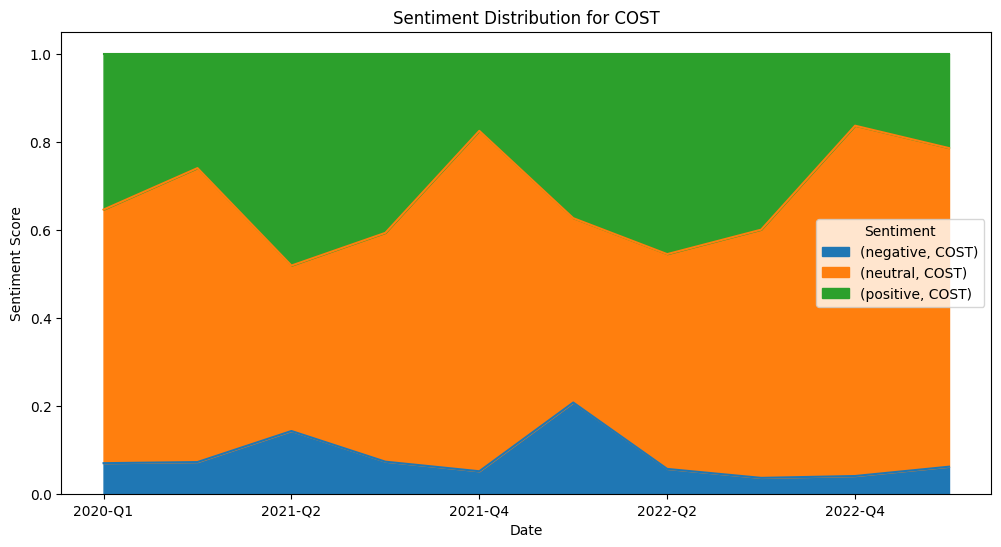

In [173]:
df_pivot = sentiment_records_cost.pivot_table(index='Quarter', columns='Ticker', values=['negative', 'neutral', 'positive'], aggfunc='mean')

df_pivot.plot.area(stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution for COST')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend(title='Sentiment')
plt.show()


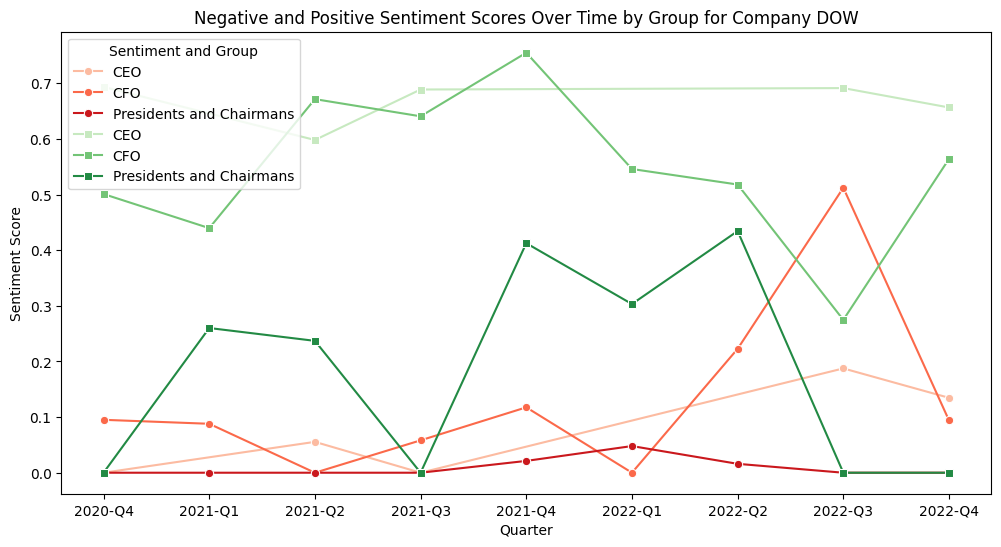

In [166]:
plt.figure(figsize=(12, 6))

# Plot negative sentiment with red color and group hue
sns.lineplot(data=sentiment_records_dow_gr, x='Quarter', y='negative', hue='Group', marker='o', palette="Reds")

# Plot positive sentiment with green color and group hue
sns.lineplot(data=sentiment_records_dow_gr, x='Quarter', y='positive', hue='Group', marker='s', palette="Greens")

plt.title('Negative and Positive Sentiment Scores Over Time by Group for Company DOW')
plt.xlabel('Quarter')
plt.ylabel('Sentiment Score')

# Update legend for clarity (to show both sentiment and group)
plt.legend(title='Sentiment and Group', loc='upper left')

plt.show()

In [141]:
sentiment_records_cost["Title"].unique()

array(['Executive Vice President, Chief Financial Officer',
       'Executive Vice President and Chief Financial Officer',
       'Director, Executive Vice President, and Chief Financial Officer',
       'Chief Financial Officer',
       'Director, Financial Planning and Investor Relations',
       'Senior Vice President, Finance and Investor Relations',
       'Senior Vice President, Financial Planning, Investor Relations, and Treasury',
       'UBS'], dtype=object)

In [113]:
sentiment_records[sentiment_records["Transcript"].isin(negative_calls["Transcript"])]

,Name,Title,Date,Exchange,Quarter,Ticker,Transcript,negative,neutral,positive,max_sentiment
991,Gregory J. Hayes,Chief Executive Officer,"Jan 26, 2021, 8:30 a.m. ET",NYSE: RTX,2020-Q4,RTX,"Prepared Remarks:\nOperator\nGood day, ladies ...",0.037412,0.503474,0.459114,neutral
992,Anthony F. O'Brien,Chief Financial Officer,"Jan 26, 2021, 8:30 a.m. ET",NYSE: RTX,2020-Q4,RTX,"Prepared Remarks:\nOperator\nGood day, ladies ...",0.090265,0.366223,0.543513,positive
993,Neil Mitchill,"Corporate Vice President, Financial Planning, ...","Jan 26, 2021, 8:30 a.m. ET",NYSE: RTX,2020-Q4,RTX,"Prepared Remarks:\nOperator\nGood day, ladies ...",0.603678,0.396322,0.000000,negative
2005,Pankaj Gupta,"Vice President, Investor Relations","Oct 20, 2022, 8:00 a.m. ET",NYSE: DOW,2022-Q3,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...",0.000000,1.000000,0.000000,neutral
2006,Jim Fitterling,Chairman and Chief Executive Officer,"Oct 20, 2022, 8:00 a.m. ET",NYSE: DOW,2022-Q3,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...",0.187510,0.121109,0.691381,positive
2007,Howard Ungerleider,President and Chief Financial Officer,"Oct 20, 2022, 8:00 a.m. ET",NYSE: DOW,2022-Q3,DOW,"Prepared Remarks:\nOperator\nGood day, and wel...",0.512254,0.212995,0.274751,negative
2648,Richard Galanti,Executive Vice President and Chief Financial O...,"Dec 09, 2021, 5:00 p.m. ET",NASDAQ: COST,2022-Q1,COST,"Prepared Remarks:\nOperator\nGood day, and tha...",0.074837,0.517409,0.407754,neutral
2649,Bob Nelson,"Senior Vice President, Financial Planning, Inv...","Dec 09, 2021, 5:00 p.m. ET",NASDAQ: COST,2022-Q1,COST,"Prepared Remarks:\nOperator\nGood day, and tha...",0.339704,0.320615,0.339681,negative


### See data for Google

In [167]:
sentiment_records_googl = sentiment_records[sentiment_records["Ticker"]=="GOOGL"]

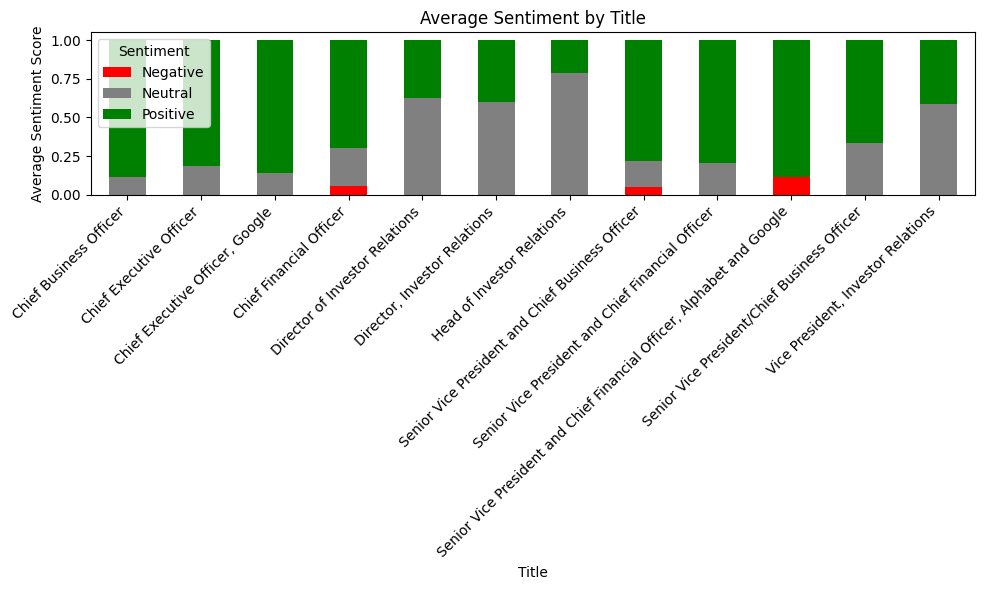

In [168]:
grouped = sentiment_records_googl.groupby("Title")[["negative", "neutral", "positive"]].mean()

# Plot the average sentiment values
grouped.plot(kind='bar', figsize=(10, 6), stacked=True, color=["red", "gray", "green"])
plt.title("Average Sentiment by Title")
plt.ylabel("Average Sentiment Score")
plt.xlabel("Title")
plt.legend(["Negative", "Neutral", "Positive"], title="Sentiment")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

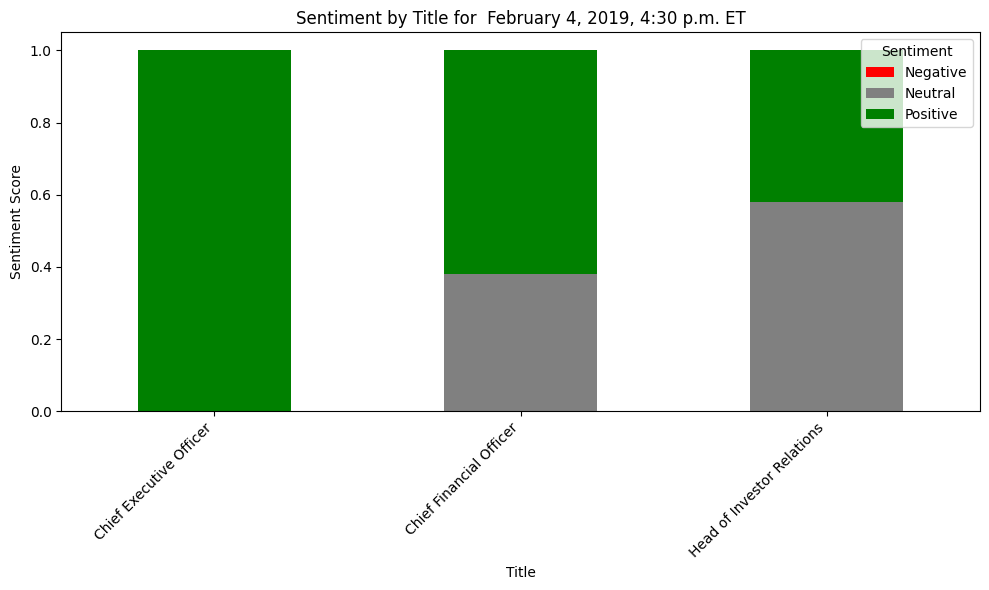

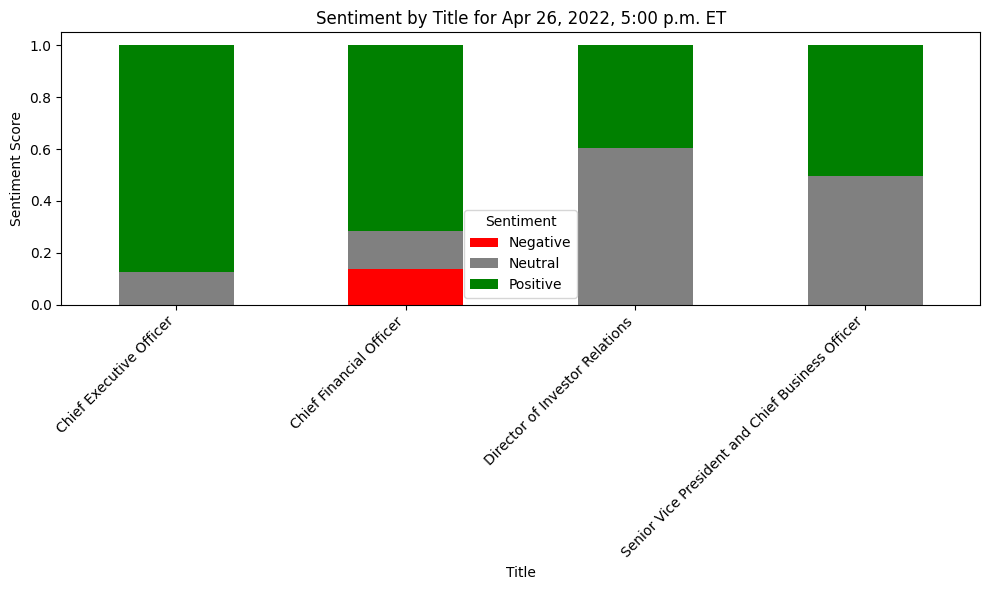

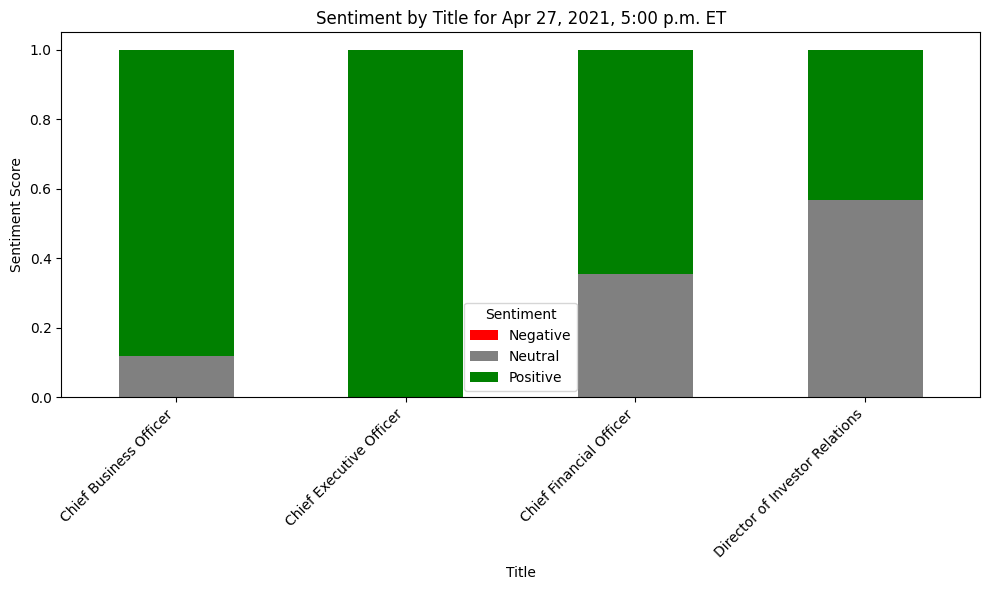

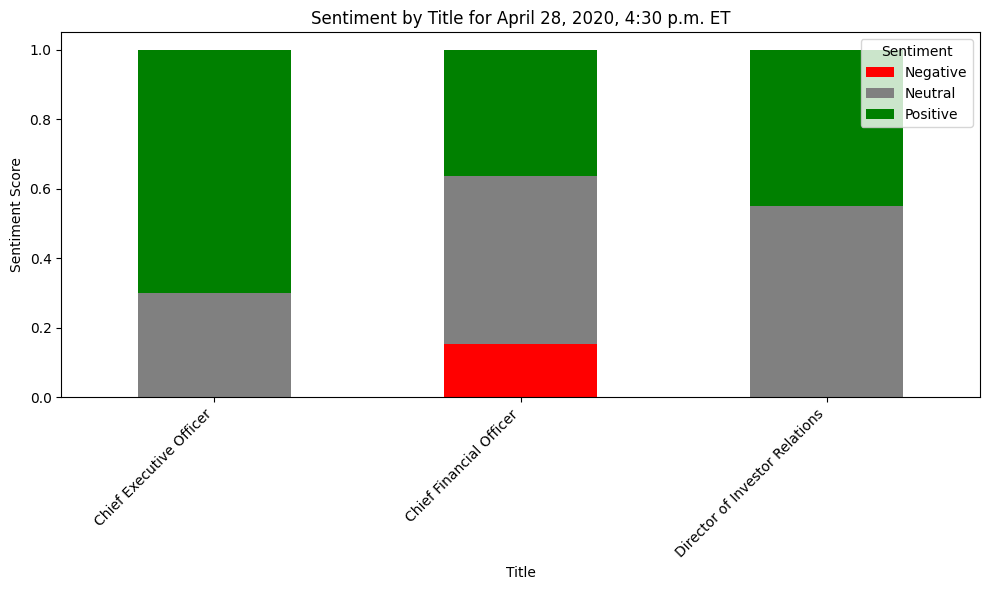

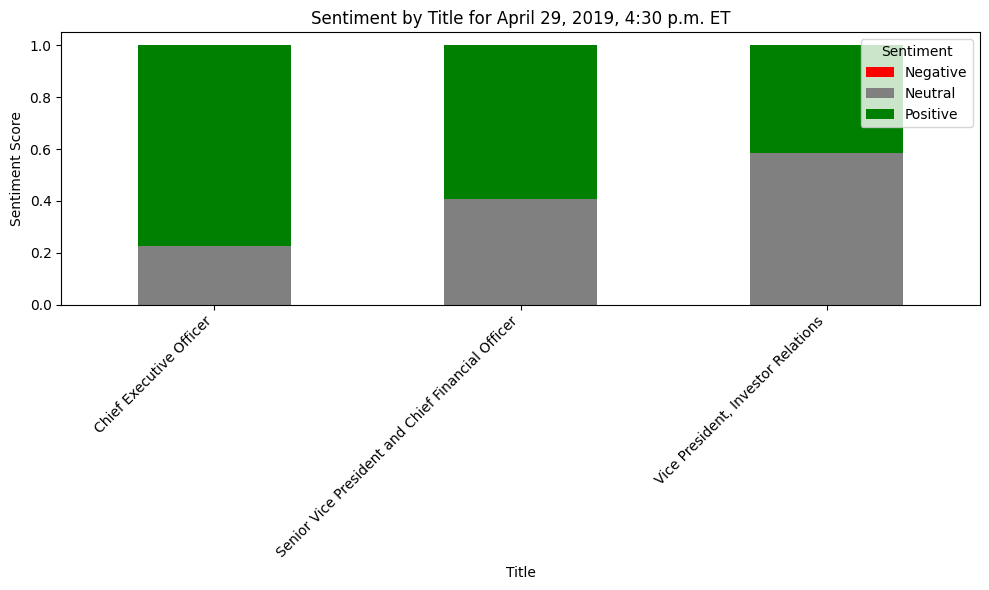

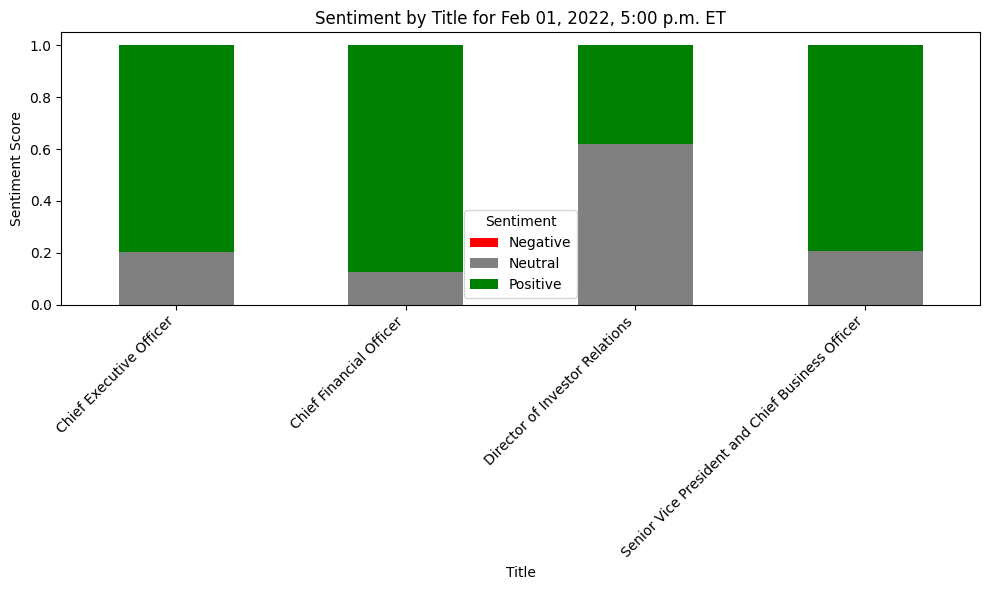

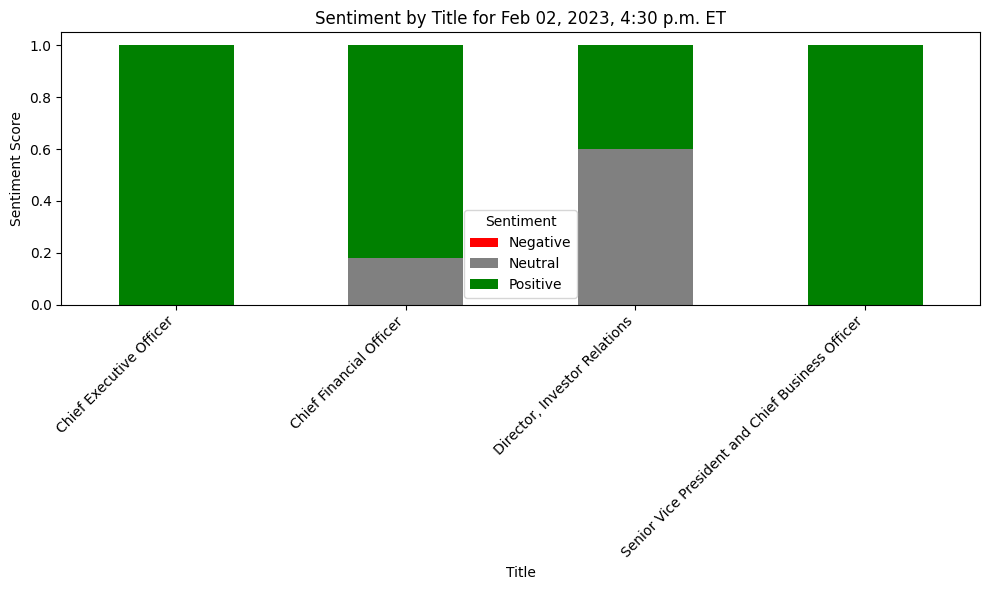

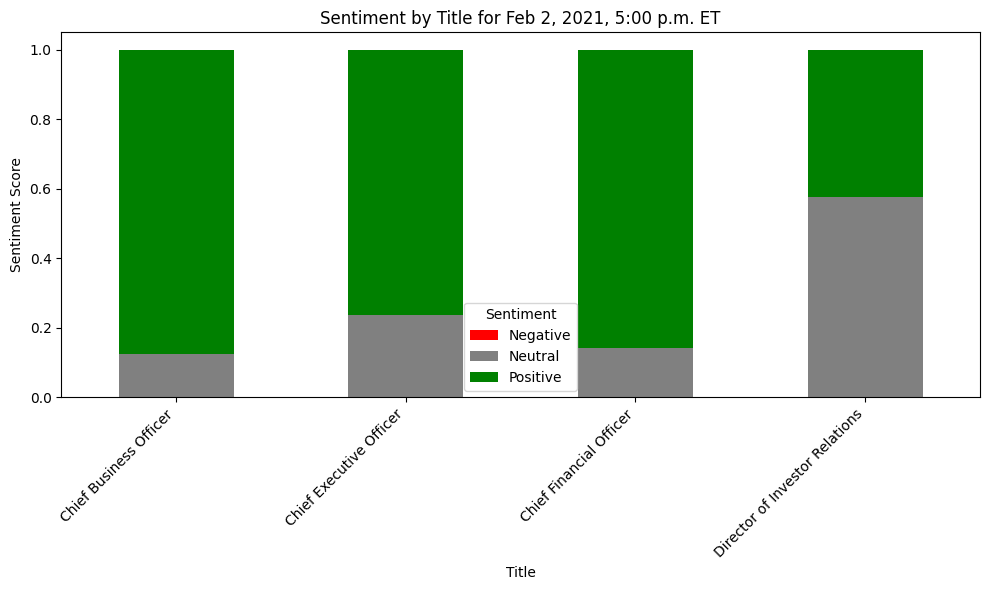

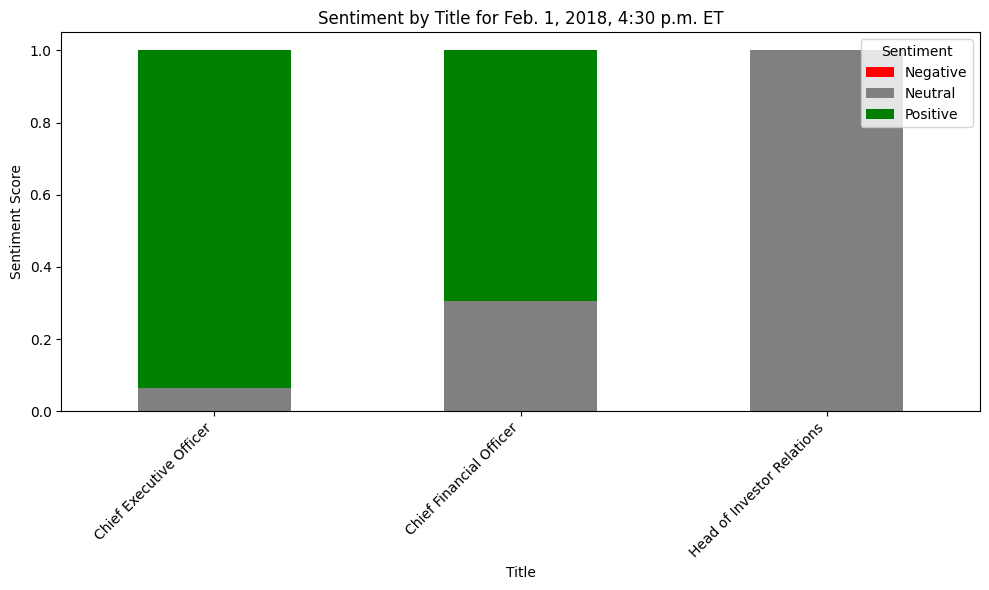

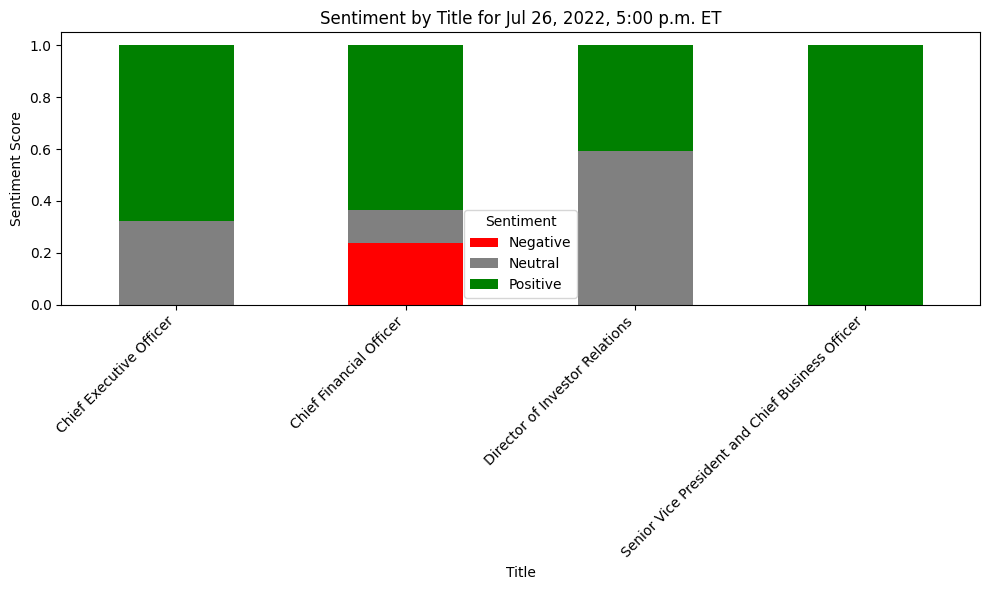

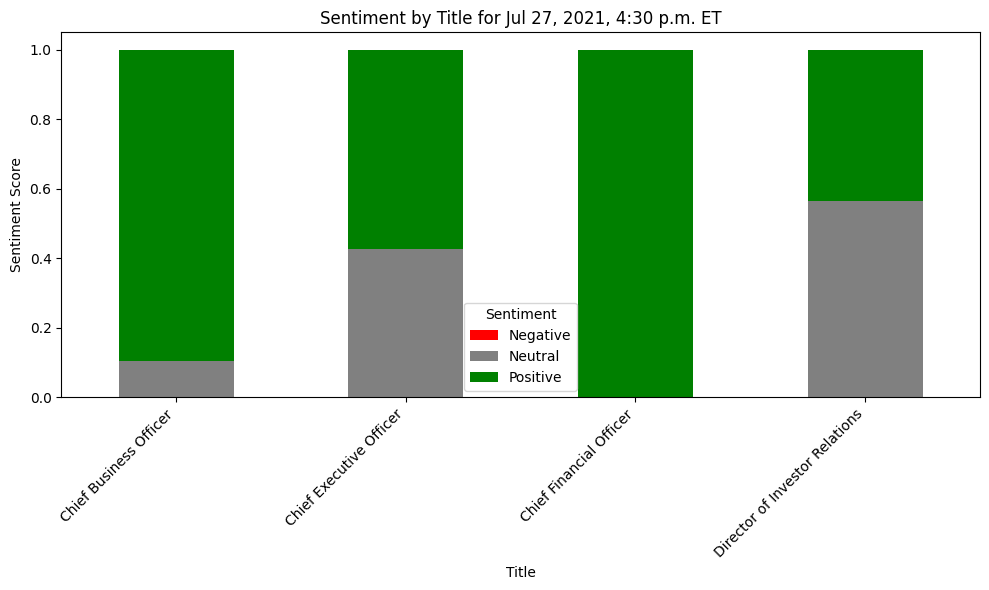

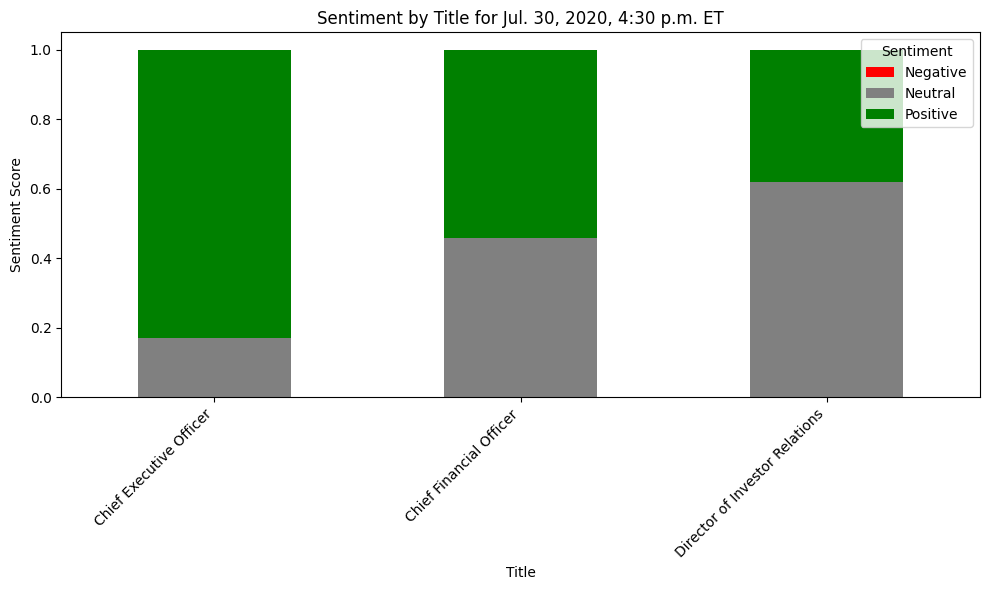

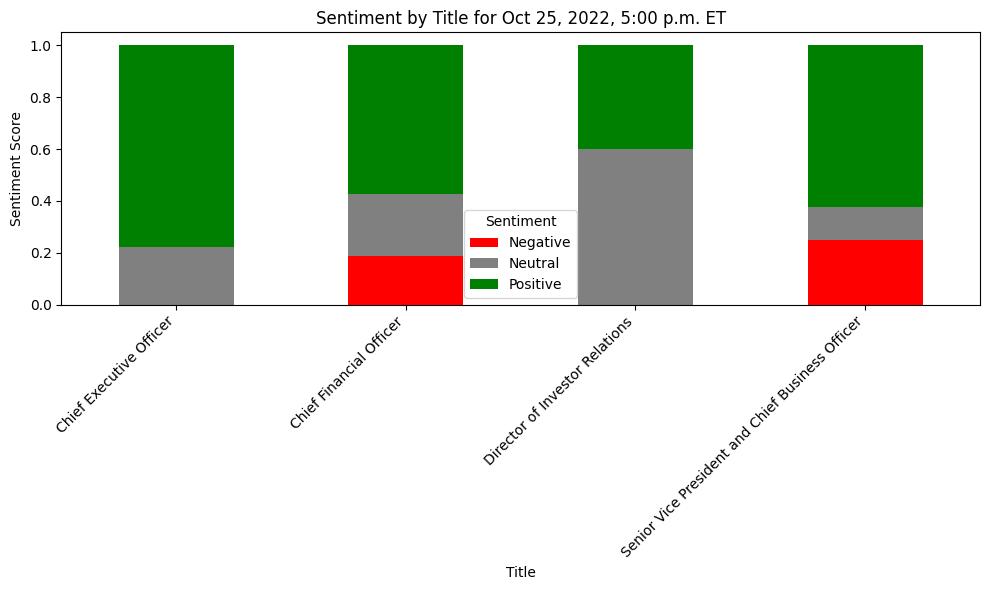

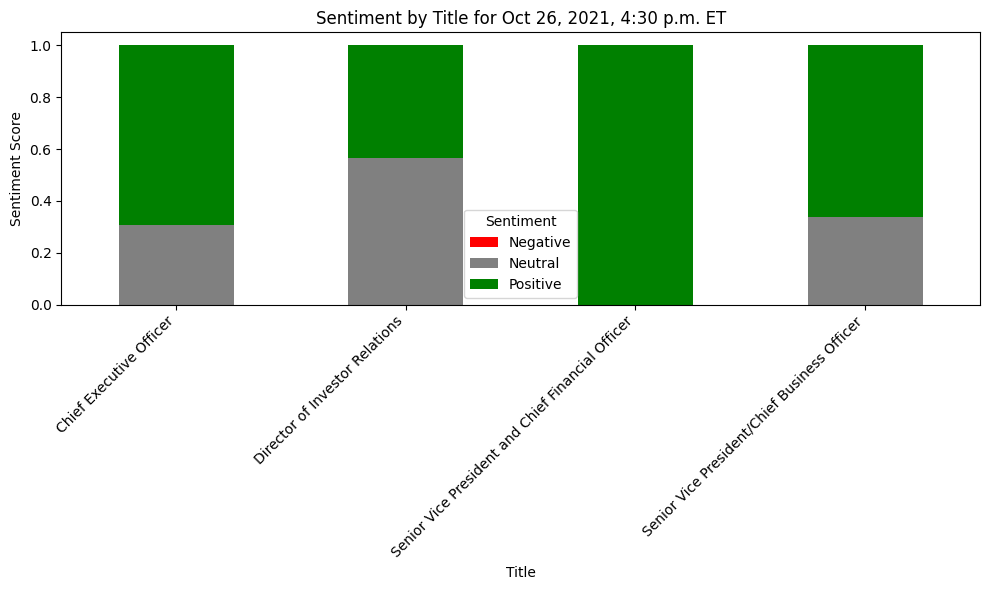

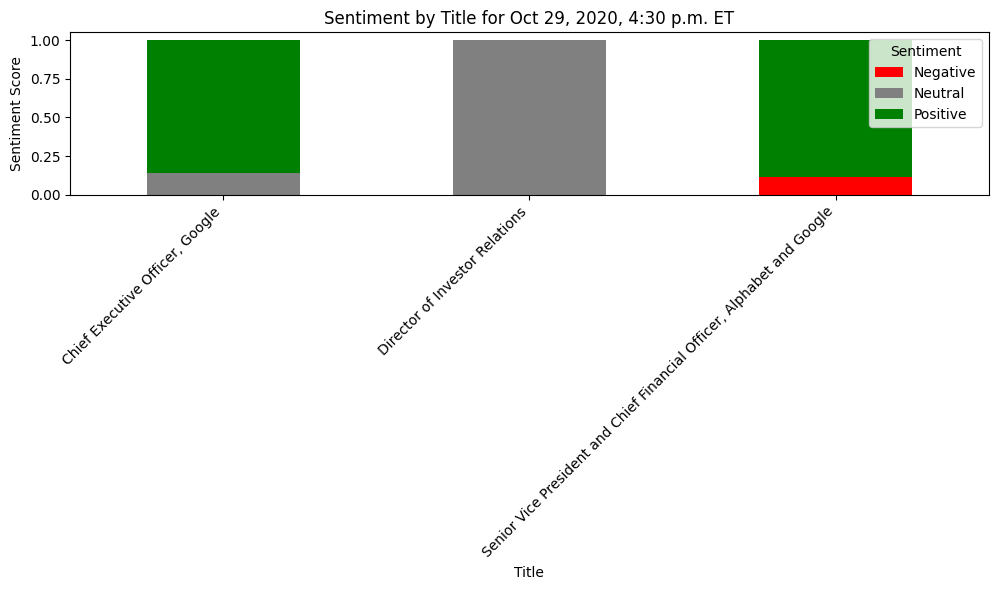

In [172]:
grouped_date_title = sentiment_records_googl.groupby(["Date", "Title"])[["negative", "neutral", "positive"]].max().reset_index()
unique_dates = grouped_date_title["Date"].unique()

for date in unique_dates:
    
    data_for_date = grouped_date_title[grouped_date_title["Date"] == date]
    
    data_for_date.set_index("Title")[["negative", "neutral", "positive"]].plot(
        kind='bar', 
        figsize=(10, 6), 
        stacked=True, 
        color=["red", "gray", "green"]
    )
    

    plt.title(f"Sentiment by Title for {date}")
    plt.ylabel("Sentiment Score")
    plt.xlabel("Title")
    plt.legend(["Negative", "Neutral", "Positive"], title="Sentiment")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Show the plot
    plt.show()
